In [116]:
########################################
# Auteur : Marine BARET
# TP Noté : Web Scraping, Prétraitement et Analyse sur des Données de PubMed
# Date : 20 décembre 2024
########################################


In [117]:
# --- Import des librairies ---

# On importe différentes librairies afin de manipuler les données, faire des requêtes HTTP,
# extraire du texte HTML, nettoyer et analyser du texte, et visualiser les résultats.
# Ces outils sont indispensables pour la partie web scraping (requests, BeautifulSoup),
# la mise en forme des données (pandas), les temporisations (time),
# les expressions régulières (re), la construction de nuages de mots (WordCloud),
# la modélisation du langage (nltk) et l'usage d'outils de machine learning (sklearn).

# On télécharge ici les ressources nécessaires à NLTK pour que les fonctions de tokenisation,
# de stopwords et de lemmatisation puissent fonctionner correctement.
# Cela prépare l'environnement linguistique pour le traitement du texte.

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
import nltk

#  Télécharger les ressources NLTK (stopwords, lemmatiser)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [123]:
########################################
# PARTIE 1 : Web Scraping
########################################



In [124]:
# Le choix du mot-clé

# Le mot-clé 'machine learning' est celui qui servira à effectuer la requête sur PubMed.
# On va extraire les articles liés à ce terme pour pouvoir ensuite analyser leur contenu.

keyword = "machine learning"

In [125]:
# Fonction utilitaire pour parser une page de résultats PubMed

# Cette fonction va prendre le contenu HTML d'une page de résultats fournie par PubMed,
# identifier les éléments contenant les articles, en extraire le titre, les auteurs,
# ainsi que l'abstract complet de chaque article.
# Le choix d'une fonction dédiée permet de séparer la logique d'extraction de la boucle principale
# de navigation dans les pages, améliorant ainsi la lisibilité et la maintenabilité du code.

# Dans la fonction parse_pubmed_page, on utilise BeautifulSoup pour parcourir la structure HTML.
# On récupère ensuite chaque bloc 'article' représentant un résultat individuel.
# On extrait le titre, les auteurs, et surtout l'URL du détail de l'article.
# À partir de l'URL de détail, on appelle une autre fonction get_abstract pour aller chercher l'abstract.
# On rassemble le tout sous forme de dictionnaires homogènes (title, authors, abstract)
# pour faciliter la conversion ultérieure en DataFrame.
# DataFrame = tableau de données

def parse_pubmed_page(html_content):
    """Parse le contenu HTML d'une page de résultats PubMed.
    Retourne une liste de dictionnaires contenant Titre, auteurs et abstract."""
    soup = BeautifulSoup(html_content, 'html.parser')

    articles_data = []
    # Chaque résultat est identifié par le tag 'article' avec class 'full-docsum'
    articles = soup.find_all('article', class_='full-docsum')

    for art in articles:
        # Extraction du titre
        title_tag = art.find('a', class_='docsum-title')
        title = title_tag.get_text(strip=True) if title_tag else None

        # Extraction des auteurs
        authors_tag = art.find('span', class_='docsum-authors full-authors')
        authors = authors_tag.get_text(strip=True) if authors_tag else None

        # Lien vers le détail de l'article où se trouve l'abstract
        detail_url = "https://pubmed.ncbi.nlm.nih.gov" + title_tag['href'] if title_tag else None

        # Récupération de l'abstract en allant sur la page de détail
        abstract = get_abstract(detail_url) if detail_url else None

        articles_data.append({
            'title': title,
            'authors': authors,
            'abstract': abstract
        })
    return articles_data



In [126]:
# Fonction get_abstract
# Cette fonction, appelée par parse_pubmed_page, envoie une requête GET sur l'URL spécifique de l'article.
# Elle récupère la page HTML et utilise BeautifulSoup pour extraire le contenu de la balise 'abstract-content'.
# On insère un léger délai (time.sleep) pour éviter de surcharger le serveur de requêtes trop rapprochées.
# Si l'extraction fonctionne, on obtient l'abstract sous forme de texte brut.


def get_abstract(article_url):
    """Récupère l'abstract d'un article à partir de son URL PubMed."""
    # On prend des pauses légères pour éviter de surcharger le serveur
    time.sleep(0.2)
    r = requests.get(article_url)
    if r.status_code != 200:
        return None
    soup = BeautifulSoup(r.text, 'html.parser')
    abstract_div = soup.find('div', class_='abstract-content selected')
    if abstract_div:
        return abstract_div.get_text(strip=True)
    return None



In [127]:
# Itération sur plusieurs pages de résultats
# PubMed génère des pages avec un paramètre 'page'. On tente par exemple les 3 premières pages.
# On exploite la pagination de PubMed en ajoutant un paramètre 'page' dans l'URL.
# Ici, on a choisi d'explorer 3 pages de résultats pour le mot-clé 'machine learning'.
# Pour chaque page, on fait une requête GET, puis on appelle parse_pubmed_page
# afin de récupérer un ensemble d'articles. Ces articles sont ajoutés à une liste globale all_articles.
# En cas d'erreur (ex: statut HTTP non 200), on arrête la boucle pour éviter des erreurs inutiles.
# On met des pauses (time.sleep) entre chaque requête afin d'être respectueux vis-à-vis des serveurs distants.

base_url = "https://pubmed.ncbi.nlm.nih.gov/?term={}&page={}"
all_articles = []
for p in range(1,4):  # On limite à 3 pages pour la recherche
    url = base_url.format(keyword.replace(" ","+"), p)
    response = requests.get(url)
    if response.status_code == 200:
        page_articles = parse_pubmed_page(response.text)
        all_articles.extend(page_articles)
    else:
        # Si la page ne répond pas, on arrête ou on ignore
        break
    time.sleep(0.5)

In [128]:
# Conversion en DataFrame
# Une fois tous les articles récupérés, on convertit la liste de dictionnaires en un DataFrame pandas.
# Cela permet d'avoir une structure tabulaire facilitant les opérations de nettoyage,
# de filtrage, d'analyse et éventuellement d'export des résultats.
# On enlève ensuite les lignes où titre ou abstract sont manquants,
# car ces informations sont essentielles à l'analyse textuelle.


df_raw = pd.DataFrame(all_articles)
# Nettoyage éventuel des lignes vides
df_raw.dropna(subset=['title', 'abstract'], inplace=True)


In [129]:
df_raw

,title,authors,abstract
0,A guide tomachinelearningfor biologists.,"Greener JG, Kandathil SM, Moffat L, Jones DT.",The expanding scale and inherent complexity of...
1,MachineLearningin Medicine.,Deo RC.,"Spurred by advances in processing power, memor..."
2,"Introduction toMachineLearning, Neural Network...","Choi RY, Coyner AS, Kalpathy-Cramer J, Chiang ...",Purpose:To present an overview of current mach...
3,eDoctor:machinelearningand the future of medic...,"Handelman GS, Kok HK, Chandra RV, Razavi AH, L...",Machine learning (ML) is a burgeoning field of...
4,SupervisedMachineLearning: A Brief Primer.,"Jiang T, Gradus JL, Rosellini AJ.",Machine learning is increasingly used in menta...
5,Machinelearningfor cardiology.,"Arfat Y, Mittone G, Esposito R, Cantalupo B, D...",This paper reviews recent cardiology literatur...
6,Machinelearningmodel for predicting malaria us...,"Lee YW, Choi JW, Shin EH.",Background:Rapid diagnosing is crucial for con...
7,A Review onMachineLearningfor EEG Signal Proce...,"Hosseini MP, Hosseini A, Ahi K.",Electroencephalography (EEG) has been a staple...
8,Review ofmachinelearningand deeplearningmodels...,"Guo W, Liu J, Dong F, Song M, Li Z, Khan MKH, ...",The ever-increasing number of chemicals has ra...
9,Machinelearningfor clinical decision support i...,"Peiffer-Smadja N, Rawson TM, Ahmad R, Buchard ...",Background:Machine learning (ML) is a growing ...


In [130]:
# Nous avons réussi à collecter les données affichées si dessus dans la variable df.
# On va utiliser NLTK  la boîte à outils de traitement du langage naturel (NLP) dans la suite du TP.
# Son rôle est de fournir des outils pour nettoyer, prétraiter et analyser les données :
# Diviser le texte en mots, phrases, tokens utiles = Tokenisation
# Réduire les mots à leur racine = Stemming ou  à la forme canonique c'est à dire la plus simple comme dans les dictionnaires = Lemmatization (étape de normalisation)
# Retrait des stopwords, ponctuations, chiffres inutiles assimilable au "bruit" des données

In [131]:
########################################
# PARTIE 2 : Analyse exploratoire et prétraitement
########################################


# On pose :

df = df_raw.copy()


# df est une copie indépendante de df_initial, contenant les mêmes données, mais modifiable sans affecter df_initial.


In [132]:
# Avant de passer à la pipeline, on définit des transformateurs personnalisés inspirés des approches vues en TD.

In [133]:
# La classe TextCleaner est un transformateur qui se concentre sur un premier nettoyage du texte brut.
# Inspiré d'une logique courante en traitement du langage, ce nettoyeur standardise la casse, élimine la ponctuation
# pour ne conserver que des caractères alphabétiques, et s’assure que les mots soient correctement séparés.
# L'objectif principal est de produire un texte simplifié et homogène, prêt pour les étapes suivantes.
# On notera notamment le passage en minuscules, suivi de l’utilisation d’une expression régulière pour extraire
# uniquement les séquences de lettres, et enfin la remise en forme du texte pour conserver une majuscule en début.
# La méthode fit, conforme à l’interface de scikit-learn, ne fait rien ici car il n’y a pas de paramètre à apprendre.
# La méthode transform réalise tout le travail de nettoyage sur chaque document.


class TextCleaner(TransformerMixin):
    """Nettoie le texte et sépare correctement les mots.
    - Met en minuscule
    - Retire la ponctuation en conservant uniquement les caractères alphabétiques
    - Sépare correctement les mots à l'aide d'une expression régulière
    - Garde le premier caractère en majuscule, le reste en minuscule
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cleaned = []
        pattern = re.compile(r"[A-Za-z]+")  # capture uniquement les séquences de lettres

        for doc in X:
            # Mettre en minuscule
            doc = doc.lower()
            # Extraire les mots alphabétiques
            words = pattern.findall(doc)
            # Rejoindre les mots avec un espace
            text = " ".join(words)
            # Retrait des espaces multiples (au cas où)
            text = re.sub(r'\s+', ' ', text).strip()
            # Premier caractère en majuscule, reste en minuscule
            if text:
                text = text.capitalize()
            cleaned.append(text)

        return cleaned




In [134]:
# Dans la classe Tokenizer, on se concentre sur la découpe du texte propre en unités lexicales (tokens).
# Cette étape est cruciale pour la suite : elle permet de manipuler le texte sous forme de liste de mots.
# Le tokeniseur utilisé est word_tokenize, proposé par NLTK, qui segmente le texte en mots individuels.
# Ainsi, on part d’une chaîne nettoyée pour obtenir un tableau de tokens plus facile à traiter.


class Tokenizer(TransformerMixin):
    """Tokenisation du texte."""
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        tokenized = []
        for doc in X:
            tokens = word_tokenize(doc)
            tokenized.append(tokens)
        return tokenized


In [135]:
# La classe StopWordsRemover illustre l’étape classique de filtrage des mots vides (stopwords).
# Ces mots, fréquents mais peu informatifs, sont retirés. Ici, on combine plusieurs sources de stopwords :
# ceux de NLTK et ceux de scikit-learn, éventuellement enrichis par une liste personnalisée.
# On obtient un ensemble de mots à ignorer, et lors de la transformation, on ne conserve que les tokens
# qui sont à la fois alphabetiques et non présents dans la liste des stopwords.
# Le but est de nettoyer encore davantage le texte en éliminant les mots qui n’apportent pas de sens
# spécifique à l’analyse.


class StopWordsRemover(TransformerMixin):
    """Retrait des stopwords à partir d'un ensemble combiné (NLTK + sklearn)"""
    def __init__(self, extra_stops=None):
        # Combiner stopwords nltk et sklearn
        base_stops = set(stopwords.words('english')) | sklearn_stopwords
        if extra_stops:
            base_stops = base_stops.union(set(extra_stops))
        self.stopwords = base_stops

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        filtered = []
        for tokens in X:
            filtered_tokens = [t for t in tokens if t not in self.stopwords and t.isalpha()]
            filtered.append(filtered_tokens)
        return filtered




In [136]:
# La classe Lemmatizer applique une lemmatisation sur chaque token.
# La lemmatisation permet de ramener chaque mot à sa forme canonique (lemmes) plutôt que la forme infléchie.
# Par exemple, “running” et “ran” deviennent “run”. Ceci unifie les variations morphologiques et facilite
# les analyses ultérieures. On utilise le WordNetLemmatizer de NLTK, un outil standard et efficace
# dans le prétraitement des textes.

class Lemmatizer(TransformerMixin):
    """Lemmatisation des tokens """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        lemmatized = []
        for tokens in X:
            lemma = [self.lemmatizer.lemmatize(t) for t in tokens]
            lemmatized.append(lemma)
        return lemmatized





In [137]:
# La classe Joiner est la dernière étape du prétraitement. Elle reconstruit à partir des tokens un texte cohérent,
# mais épuré. Cette étape est utile lorsqu’on a besoin de fournir le texte final sous forme de chaîne,
# par exemple pour alimenter un modèle qui travaille sur du texte brut (après nettoyage) plutôt que sur des listes
# de tokens.


class Joiner(TransformerMixin):
    """Rejoint la liste de tokens en une seule chaîne de caractères après prétraitement"""
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        joined = [" ".join(tokens) for tokens in X]
        return joined



In [138]:
# Nous allons créer deux pipelines : une pour les titres, une pour les abstracts

# Les pipelines "title_pipeline" et "abstract_pipeline" sont des flux de transformations séquentielles.
# L’idée est de chaîner les étapes décrites ci-dessus dans un ordre logique :
# 1. Nettoyage du texte (TextCleaner)
# 2. Tokenisation (Tokenizer)
# 3. Suppression des stopwords (StopWordsRemover)
# 4. Lemmatisation (Lemmatizer)
# 5. Reconstruction d’une chaîne propre (Joiner)

# En combinant ces étapes dans un Pipeline scikit-learn, on rend le processus reproductible, maintenable
# et facile à déployer. Chaque pipeline peut être appliqué à un type de texte particulier (ici, les titres et les résumés).

title_pipeline = Pipeline([
    ('clean', TextCleaner()),
    ('tokenize', Tokenizer()),
    ('remove_stops', StopWordsRemover()),
    ('lemmatize', Lemmatizer()),
    ('join', Joiner())
])

abstract_pipeline = Pipeline([
    ('clean', TextCleaner()),
    ('tokenize', Tokenizer()),
    ('remove_stops', StopWordsRemover()),
    ('lemmatize', Lemmatizer()),
    ('join', Joiner())
])


In [139]:
# Application des pipelines
df['clean_title'] = title_pipeline.fit_transform(df['title'])
df['clean_abstract'] = abstract_pipeline.fit_transform(df['abstract'])

# Les appels à "fit_transform" sur df['title'] et df['abstract'] appliquent le pipeline sur chaque série de données.
# "fit_transform" entraîne, si nécessaire, les différentes étapes (par exemple, la lemmatisation n’a pas vraiment besoin
# d’apprentissage, mais certaines étapes pourraient en avoir) puis applique les transformations en série.
# Au final, on obtient deux nouvelles colonnes dans le DataFrame : "clean_title" et "clean_abstract",
# qui contiennent la version nettoyée et prétraitée des titres et des résumés.




In [140]:
df

,title,authors,abstract,clean_title,clean_abstract
0,A guide tomachinelearningfor biologists.,"Greener JG, Kandathil SM, Moffat L, Jones DT.",The expanding scale and inherent complexity of...,A guide tomachinelearningfor biologist,The expanding scale inherent complexity biolog...
1,MachineLearningin Medicine.,Deo RC.,"Spurred by advances in processing power, memor...",Machinelearningin medicine,Spurred advance processing power memory storag...
2,"Introduction toMachineLearning, Neural Network...","Choi RY, Coyner AS, Kalpathy-Cramer J, Chiang ...",Purpose:To present an overview of current mach...,Introduction tomachinelearning neural network ...,Purpose present overview current machine learn...
3,eDoctor:machinelearningand the future of medic...,"Handelman GS, Kok HK, Chandra RV, Razavi AH, L...",Machine learning (ML) is a burgeoning field of...,Edoctor machinelearningand future medicine,Machine learning ml burgeoning field medicine ...
4,SupervisedMachineLearning: A Brief Primer.,"Jiang T, Gradus JL, Rosellini AJ.",Machine learning is increasingly used in menta...,Supervisedmachinelearning brief primer,Machine learning increasingly used mental heal...
5,Machinelearningfor cardiology.,"Arfat Y, Mittone G, Esposito R, Cantalupo B, D...",This paper reviews recent cardiology literatur...,Machinelearningfor cardiology,This paper review recent cardiology literature...
6,Machinelearningmodel for predicting malaria us...,"Lee YW, Choi JW, Shin EH.",Background:Rapid diagnosing is crucial for con...,Machinelearningmodel predicting malaria using ...,Background rapid diagnosing crucial controllin...
7,A Review onMachineLearningfor EEG Signal Proce...,"Hosseini MP, Hosseini A, Ahi K.",Electroencephalography (EEG) has been a staple...,A review onmachinelearningfor eeg signal proce...,Electroencephalography eeg staple method ident...
8,Review ofmachinelearningand deeplearningmodels...,"Guo W, Liu J, Dong F, Song M, Li Z, Khan MKH, ...",The ever-increasing number of chemicals has ra...,Review ofmachinelearningand deeplearningmodels...,The increasing number chemical raised public c...
9,Machinelearningfor clinical decision support i...,"Peiffer-Smadja N, Rawson TM, Ahmad R, Buchard ...",Background:Machine learning (ML) is a growing ...,Machinelearningfor clinical decision support i...,Background machine learning ml growing field m...


In [141]:
########################################
# PARTIE 3 : Visualisations
########################################


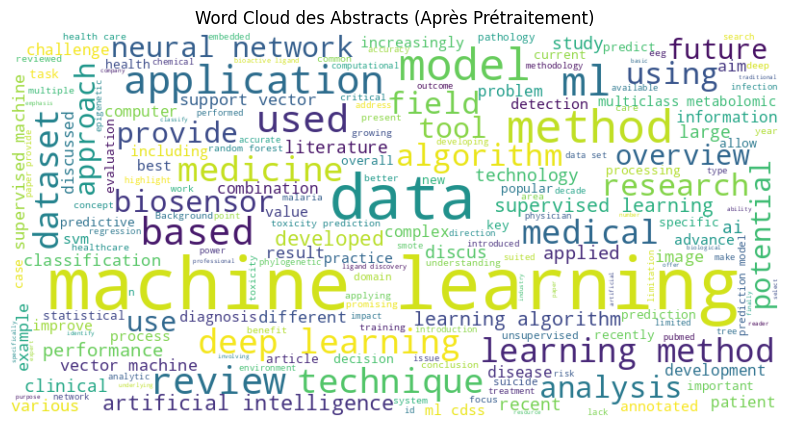

In [142]:
# Nuage de mots à partir des abstracts nettoyés

# On commence par agréger tous les textes des abstracts nettoyés en une seule grande chaîne.
# L'idée est d'avoir une vision globale de l'ensemble des termes utilisés dans notre corpus,
# ce qui permettra notamment de générer un nuage de mots (wordcloud) et d’étudier la fréquence
# des mots. En concaténant tout, on obtient une représentation très dense et représentative
# du vocabulaire employé.

all_abstract_text = " ".join(df['clean_abstract'])

# Le nuage de mots (WordCloud) est un outil visuel qui permet de synthétiser l’information textuelle
# en affichant les mots les plus fréquents de manière proportionnelle à leur occurrence.
# Ici, on précise la taille de l’image (width, height), la couleur de fond (background_color),
# puis on génère ce nuage à partir de la chaîne de tous les abstracts.
# L’objectif est d’identifier rapidement les termes-clés, de repérer les dominantes lexicales,
# et éventuellement d’esquisser des hypothèses sur la nature des sujets traités dans les articles.


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_abstract_text)



# On affiche le nuage de mots à l’aide de matplotlib, en désactivant les axes (axis("off")) pour
# se concentrer sur le contenu textuel. Le titre contextualise l’image, rappelant que les abstracts
# ont été prétraités (nettoyage, normalisation, etc.), assurant au lecteur que les mots visualisés
# sont plus fiables (moins de bruits, pas de mots vides ou mal filtrés).

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des Abstracts (Après Prétraitement)")
plt.show()




In [143]:
# Calcul de la fréquence des mots dans les abstracts


# Après cette visualisation qualitative, on passe à une analyse plus quantitative. On segmente
# la grande chaîne de caractères en tokens (splitting par espaces), ce qui nous donne la liste
# de tous les mots. Ensuite, on calcule la fréquence de chaque terme grâce à la classe Counter
# de collections, qui permet d’obtenir très rapidement un histogramme des fréquences.
# On en récupère les 20 plus fréquents (most_common(20)), ce qui nous fournit un aperçu synthétique
# des mots les plus présents dans notre corpus.


abstract_tokens = all_abstract_text.split()
word_counts = Counter(abstract_tokens)
common_words = word_counts.most_common(20)  # On affiche les 20 plus fréquents


# Ces 20 mots les plus fréquents nous donneront un focus thématique immédiat : ce sont souvent
# eux qui reflètent l'essence des sujets abordés ou les concepts clés récurrents dans les documents.
# La liste common_words offre donc un point de départ pour une analyse plus approfondie,
# comme le regroupement sémantique ou la détection de thèmes dominants.



In [144]:
common_words


[('learning', 139),
 ('machine', 105),
 ('data', 71),
 ('method', 52),
 ('model', 37),
 ('ml', 34),
 ('algorithm', 28),
 ('application', 25),
 ('used', 24),
 ('deep', 24),
 ('review', 23),
 ('based', 23),
 ('supervised', 21),
 ('technique', 20),
 ('medicine', 20),
 ('research', 19),
 ('network', 18),
 ('medical', 18),
 ('prediction', 17),
 ('field', 16)]

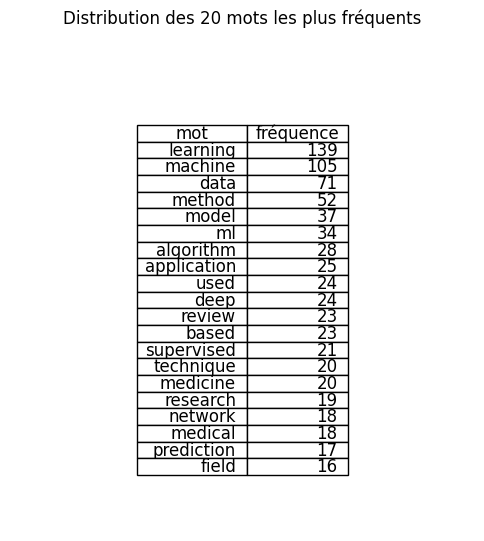

In [145]:
# On transforme la liste de tuples (mot, fréquence) en un DataFrame
# pour pouvoir l’afficher facilement sous forme de tableau. Cela permet de bénéficier des fonctionnalités
# de pandas en termes de présentation et de manipulation des données.

df_common = pd.DataFrame(common_words, columns=['mot', 'fréquence'])

# Pour obtenir une visualisation de type tableau dans une figure matplotlib,
# on utilise la méthode table() qui va intégrer les données du DataFrame
# au sein d’un axe (axis) matplotlib sous forme de table.
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('off')  # On masque les axes pour se concentrer uniquement sur le tableau
table = ax.table(
    cellText=df_common.values,
    colLabels=df_common.columns,
    loc='center'  # Le tableau est centré dans la figure
)

# On peut ajuster la taille des cellules, le style de police, etc.
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df_common.columns))))

# Affiche le tableau
plt.title("Distribution des 20 mots les plus fréquents", y=1.08)  # Ajuster la position du titre
plt.show()


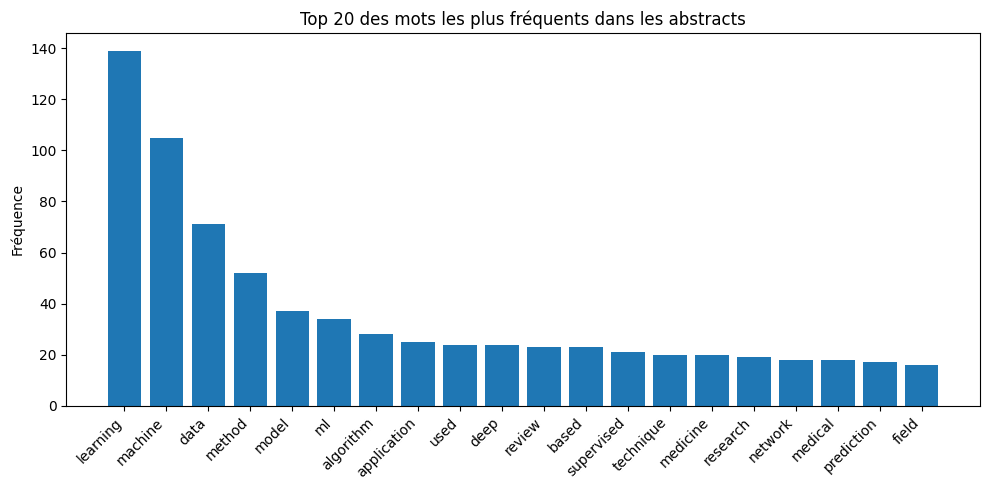

In [146]:
# Visualisation de la distribution des mots les plus fréquents

# Pour renforcer la lisibilité et l’exploitation de ces informations, on réalise un graphique
# en barres avec matplotlib. Ce graphique montrera le classement des mots les plus fréquents
# sous forme d’histogramme, permettant de visualiser clairement la hiérarchie entre eux.
# Les paramètres figsize et xticks visent à assurer une présentation optimale du graphique,
# tandis que le titre contextualise encore une fois le visuel. Le tight_layout()
# permet d’ajuster automatiquement les marges, garantissant une meilleure lisibilité.

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 des mots les plus fréquents dans les abstracts")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


In [147]:
########################################
# Test supplémentaire non demandé pour essayer d'améliorer la séparation des mots
# Supposons que nous ayons déjà exécuté le code précédent,
# y compris la génération de 'common_words'.
# Les 'common_words' sont une liste de tuples (mot, fréquence).
########################################

# Extraction de la liste des mots communs
common_word_list = [w for w, _ in common_words]

from sklearn.base import TransformerMixin

# Transformateur pour utiliser les mots communs comme délimiteurs
class CommonWordsDelimiter(TransformerMixin):
    """
    Utilise les mots fréquents comme délimiteurs pour séparer le texte en segments.
    Chaque occurrence d'un mot commun est considérée comme une coupure,
    permettant de segmenter le texte en plusieurs parties.
    """
    def __init__(self, delimiters):
        self.delimiters = set(delimiters)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        processed = []
        for doc in X:
            tokens = doc.split()
            segments = []
            current_segment = []
            for t in tokens:
                if t in self.delimiters:
                    # Si le token est un délimiteur, on clôt le segment courant
                    if current_segment:
                        segments.append(" ".join(current_segment))
                        current_segment = []
                else:
                    current_segment.append(t)
            # Ajouter le dernier segment s'il en existe un
            if current_segment:
                segments.append(" ".join(current_segment))

            # Vous pouvez choisir le caractère de jonction ; ici, on utilise " | " pour visualiser les segments
            processed.append(" | ".join(segments))
        return processed

# Application du nouveau transformateur
df['segmented_abstract'] = CommonWordsDelimiter(common_word_list).fit_transform(df['clean_abstract'])

# De même, si vous le souhaitez, vous pouvez l'appliquer aux titres :
df['segmented_title'] = CommonWordsDelimiter(common_word_list).fit_transform(df['clean_title'])


In [148]:
df

,title,authors,abstract,clean_title,clean_abstract,segmented_abstract,segmented_title
0,A guide tomachinelearningfor biologists.,"Greener JG, Kandathil SM, Moffat L, Jones DT.",The expanding scale and inherent complexity of...,A guide tomachinelearningfor biologist,The expanding scale inherent complexity biolog...,The expanding scale inherent complexity biolog...,A guide tomachinelearningfor biologist
1,MachineLearningin Medicine.,Deo RC.,"Spurred by advances in processing power, memor...",Machinelearningin medicine,Spurred advance processing power memory storag...,Spurred advance processing power memory storag...,Machinelearningin
2,"Introduction toMachineLearning, Neural Network...","Choi RY, Coyner AS, Kalpathy-Cramer J, Chiang ...",Purpose:To present an overview of current mach...,Introduction tomachinelearning neural network ...,Purpose present overview current machine learn...,Purpose present overview current | use | focus...,Introduction tomachinelearning neural | deeple...
3,eDoctor:machinelearningand the future of medic...,"Handelman GS, Kok HK, Chandra RV, Razavi AH, L...",Machine learning (ML) is a burgeoning field of...,Edoctor machinelearningand future medicine,Machine learning ml burgeoning field medicine ...,Machine | burgeoning | huge resource applied f...,Edoctor machinelearningand future
4,SupervisedMachineLearning: A Brief Primer.,"Jiang T, Gradus JL, Rosellini AJ.",Machine learning is increasingly used in menta...,Supervisedmachinelearning brief primer,Machine learning increasingly used mental heal...,Machine | increasingly | mental health | poten...,Supervisedmachinelearning brief primer
5,Machinelearningfor cardiology.,"Arfat Y, Mittone G, Esposito R, Cantalupo B, D...",This paper reviews recent cardiology literatur...,Machinelearningfor cardiology,This paper review recent cardiology literature...,This paper | recent cardiology literature repo...,Machinelearningfor cardiology
6,Machinelearningmodel for predicting malaria us...,"Lee YW, Choi JW, Shin EH.",Background:Rapid diagnosing is crucial for con...,Machinelearningmodel predicting malaria using ...,Background rapid diagnosing crucial controllin...,Background rapid diagnosing crucial controllin...,Machinelearningmodel predicting malaria using ...
7,A Review onMachineLearningfor EEG Signal Proce...,"Hosseini MP, Hosseini A, Ahi K.",Electroencephalography (EEG) has been a staple...,A review onmachinelearningfor eeg signal proce...,Electroencephalography eeg staple method ident...,Electroencephalography eeg staple | identifyin...,A | onmachinelearningfor eeg signal processing...
8,Review ofmachinelearningand deeplearningmodels...,"Guo W, Liu J, Dong F, Song M, Li Z, Khan MKH, ...",The ever-increasing number of chemicals has ra...,Review ofmachinelearningand deeplearningmodels...,The increasing number chemical raised public c...,The increasing number chemical raised public c...,Review ofmachinelearningand deeplearningmodels...
9,Machinelearningfor clinical decision support i...,"Peiffer-Smadja N, Rawson TM, Ahmad R, Buchard ...",Background:Machine learning (ML) is a growing ...,Machinelearningfor clinical decision support i...,Background machine learning ml growing field m...,Background | growing | narrative | describes c...,Machinelearningfor clinical decision support i...


In [ ]:
########################################
# Fin du TP
########################################